In [1]:
# Core libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    roc_auc_score
)
from scipy.stats import chi2_contingency, ttest_ind
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool
import shap

In [2]:
# Load and inspect data
df = pd.read_csv("adult23.csv")

feature_cols = [
    'AGEP_A', 'SEX_A', 'RACEALLP_A', 'EDUCP_A', 'BMICAT_A', 'SMKCIGST_A',
    'HYPEV_A', 'CHLEV_A', 'DIBLAST1_A', 'DEPEV_A', 'COPDEV_A', 'STREV_A',
    'ASEV_A', 'ANXEV_A', 'ANXMED_A', 'DEPFREQ_A', 'ANXFREQ_A', 'REGION', 'URBRRL',
    'NOTCOV_A', 'PRDEDUC1_A', 'EMPLASTWK_A', 'PLN1PAY4_A', 'PLN1PAY5_A', 'PLN1PAY6_A',
    'CANEV_A', 'ARTHEV_A'
]
target_cols = ['CHDEV_A', 'ANGEV_A', 'MIEV_A']
df = df[feature_cols + target_cols].copy()

In [3]:
# Map survey codes
# The mapping of the actual responses to their numerical equivalents was AI-assisted through the use of ChatGPT.
def map_codes(col, mapping, unknown="Unknown"):
    return col.replace(mapping).mask(col.isna(), pd.NA).fillna(unknown).astype("string")

binary_map_cols = ['HYPEV_A', 'CHLEV_A', 'DEPEV_A', 'COPDEV_A', 'STREV_A', 'ASEV_A', 'ANXEV_A', 'ANXMED_A',
                   'PLN1PAY4_A', 'PLN1PAY5_A', 'PLN1PAY6_A', 'CANEV_A', 'ARTHEV_A']
for col in binary_map_cols:
    df[col] = map_codes(df[col], {1: "Yes", 2: "No"})

df["SEX_A"] = map_codes(df["SEX_A"], {1: "Male", 2: "Female"})
df["RACEALLP_A"] = map_codes(df["RACEALLP_A"], {
    1: "Hispanic", 2: "White-NH", 3: "Black-NH", 4: "Asian-NH",
    5: "AIAN-NH", 6: "AIAN+Other", 7: "Other"
})
df["EDUCP_A"] = map_codes(df["EDUCP_A"], {
    0: "None/KG", 1: "1-11th", 2: "12th/no dip", 3: "GED",
    4: "HS Grad", 5: "Some College", 6: "Assoc-Occ/Voc",
    7: "Assoc-Acad", 8: "Bachelor", 9: "Master", 10: "Prof/PhD"
})
df["BMICAT_A"] = map_codes(df["BMICAT_A"], {
    1: "Underweight", 2: "Normal", 3: "Overweight", 4: "Obese", 5: "Extremely Obese"
})
df["SMKCIGST_A"] = map_codes(df["SMKCIGST_A"], {
    1: "Every day", 2: "Some days", 3: "Former", 4: "Never"
})
df["DEPFREQ_A"] = map_codes(df["DEPFREQ_A"], {
    1: "Daily", 2: "Weekly", 3: "Monthly", 4: "Few times/year", 5: "Never"
})
df["ANXFREQ_A"] = map_codes(df["ANXFREQ_A"], {
    1: "Daily", 2: "Weekly", 3: "Monthly", 4: "Few times/year", 5: "Never"
})
df["NOTCOV_A"] = map_codes(df["NOTCOV_A"], {1: "Yes", 2: "No"})
df["PRDEDUC1_A"] = map_codes(df["PRDEDUC1_A"], {
    1: "<$500", 2: "$500-1999", 3: "$2000-2999", 4: "$3000+", 5: "No deductible"
})
df["EMPLASTWK_A"] = map_codes(df["EMPLASTWK_A"], {1: "Yes", 2: "No", 3: "Unable to work"})
df["REGION"] = map_codes(df["REGION"], {1: "Northeast", 2: "Midwest", 3: "South", 4: "West"})
df["URBRRL"] = map_codes(df["URBRRL"], {
    1: "Large Central", 2: "Large Fringe", 3: "Medium Metro", 4: "Small/Nonmetro"
})

diblast1_mapping = {
    0: "Never",
    1: "Within past year",
    2: "Within 2 years",
    3: "Within 3 years",
    4: "Within 5 years",
    5: "Within 10 years",
    6: "10+ years ago",
    7: "Refused",
    8: "Not Ascertained",
    9: "Don't Know"
}
df["DIBLAST1_A"] = map_codes(df["DIBLAST1_A"], diblast1_mapping)

df["AGEP_A"] = pd.to_numeric(df["AGEP_A"], errors="coerce")
df = df.dropna(subset=["AGEP_A"])

In [4]:
# Drop columns with >50% missing
thresh = len(df) * 0.5
df = df.dropna(axis=1, thresh=thresh)

In [5]:
#  Build target variable
df["heart_disease"] = ((df["CHDEV_A"] == 1) | (df["ANGEV_A"] == 1) | (df["MIEV_A"] == 1)).astype(int)
df = df.drop(columns=target_cols)

X = df.drop(columns="heart_disease")
y = df["heart_disease"]

In [6]:
# Impute missing values
categorical_features = X.select_dtypes(include="string").columns.tolist()
numeric_cols = [col for col in X.columns if col not in categorical_features]

for col in categorical_features:
    if df[col].isna().sum() > 0:
        df[col] = df[col].fillna(df[col].mode(dropna=True)[0])
for col in numeric_cols:
    if df[col].isna().sum() > 0:
        df[col] = df[col].fillna(df[col].median())

In [7]:
# One-hot encoding
ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)
ct = ColumnTransformer(
    [("onehot", ohe, categorical_features)],
    remainder="passthrough"
)
X_encoded = ct.fit_transform(df[categorical_features + numeric_cols])
encoded_col_names = ct.named_transformers_["onehot"].get_feature_names(categorical_features).tolist()
X_final = pd.DataFrame(X_encoded, columns=encoded_col_names + numeric_cols, index=df.index)

In [8]:
# Data leakage check
leak_check = [col for col in X_final.columns if 'CHDEV' in col or 'MIEV' in col or 'ANGEV' in col]
print("Potential leakage columns in X_final:", leak_check)

Potential leakage columns in X_final: []


In [9]:
# Chi-Square & T-Test
df_stats = df.copy()

chi2_results = []
for col in categorical_features:
    tbl = pd.crosstab(df_stats[col].fillna("Missing"), df_stats["heart_disease"])
    if tbl.shape[0] > 1:
        chi2, p, dof, expected = chi2_contingency(tbl)
        chi2_results.append({"feature": col, "chi2_stat": chi2, "p_value": p})
chi2_df = pd.DataFrame(chi2_results).sort_values("p_value")

ttest_results = []
for col in numeric_cols:
    grp0 = df_stats[df_stats["heart_disease"] == 0][col].dropna()
    grp1 = df_stats[df_stats["heart_disease"] == 1][col].dropna()
    if len(grp0) > 1 and len(grp1) > 1:
        t_stat, p = ttest_ind(grp0, grp1, equal_var=False)
        ttest_results.append({"feature": col, "t_stat": t_stat, "p_value": p})
t_df = pd.DataFrame(ttest_results).sort_values("p_value") if ttest_results else pd.DataFrame()

selected_cats = chi2_df[chi2_df["p_value"] < 0.05]["feature"].tolist()
selected_nums = t_df[t_df["p_value"] < 0.05]["feature"].tolist()
selected_features = selected_cats + selected_nums

print("Selected features (p < 0.05):", selected_features)
final_columns = [col for col in X_final.columns if any(f in col for f in selected_features)]
X_filtered = X_final[final_columns]

Selected features (p < 0.05): ['HYPEV_A', 'CHLEV_A', 'DIBLAST1_A', 'EMPLASTWK_A', 'ARTHEV_A', 'COPDEV_A', 'STREV_A', 'CANEV_A', 'PRDEDUC1_A', 'SMKCIGST_A', 'PLN1PAY4_A', 'PLN1PAY6_A', 'PLN1PAY5_A', 'EDUCP_A', 'DEPFREQ_A', 'RACEALLP_A', 'NOTCOV_A', 'SEX_A', 'URBRRL', 'BMICAT_A', 'DEPEV_A', 'ANXFREQ_A', 'REGION', 'ANXMED_A', 'ANXEV_A', 'ASEV_A', 'AGEP_A']


In [10]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y, test_size=0.2, stratify=y, random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape :", X_test.shape)

Train shape: (23617, 145)
Test shape : (5905, 145)


In [11]:
# Logistic regression model
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.92      0.99      0.96      5422
           1       0.49      0.08      0.14       483

    accuracy                           0.92      5905
   macro avg       0.71      0.54      0.55      5905
weighted avg       0.89      0.92      0.89      5905



In [12]:
# Optimize logisitic regression model using hyperparameter tuning via GridSearch
lr = LogisticRegression(max_iter=1000)

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['liblinear', 'lbfgs'],
    'class_weight': ['balanced'] 
}

grid_search = GridSearchCV(
    estimator=lr,
    param_grid=param_grid,
    scoring='f1',    
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)
best_lr_model = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}


In [13]:
# Log reg model after hyperparameter tuning
y_pred = best_lr_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.74      0.84      5422
           1       0.21      0.77      0.33       483

    accuracy                           0.74      5905
   macro avg       0.59      0.76      0.59      5905
weighted avg       0.91      0.74      0.80      5905



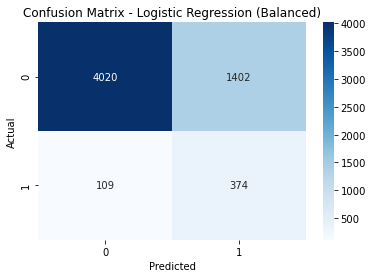

In [14]:
# Log reg confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression (Balanced)")
plt.show()

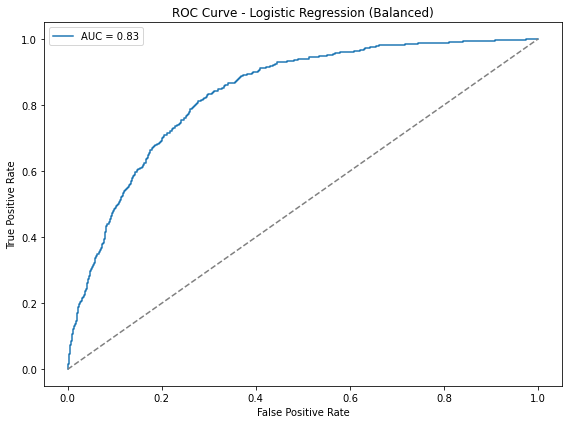

In [15]:
# Log reg ROC curve
y_proba = best_lr_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression (Balanced)')
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
# Random forest model
rf_model = RandomForestClassifier(
    n_estimators=100,        
    class_weight='balanced', 
    random_state=42,          
    n_jobs=-1                
)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96      5422
           1       0.54      0.03      0.06       483

    accuracy                           0.92      5905
   macro avg       0.73      0.51      0.51      5905
weighted avg       0.89      0.92      0.88      5905



In [17]:
# Optimize random forest model using hyperparameter tuning via GridSearch
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 10],
    'class_weight': ['balanced']
}

grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid,
    cv=5,
    scoring='f1',
    verbose=2
)

grid_rf.fit(X_train, y_train)
best_rf_model = grid_rf.best_estimator_
print("Best RF parameters:", grid_rf.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END class_weight=balanced, max_depth=None, min_samples_split=2, n_estimators=100; total time=   3.2s
[CV] END class_weight=balanced, max_depth=None, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END class_weight=balanced, max_depth=None, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END class_weight=balanced, max_depth=None, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END class_weight=balanced, max_depth=None, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END class_weight=balanced, max_depth=None, min_samples_split=2, n_estimators=200; total time=   1.5s
[CV] END class_weight=balanced, max_depth=None, min_samples_split=2, n_estimators=200; total time=   1.6s
[CV] END class_weight=balanced, max_depth=None, min_samples_split=2, n_estimators=200; total time=   1.6s
[CV] END class_weight=balanced, max_depth=None, min_samples_split=2, n_estimators=200; tota

In [18]:
# Random forest model after hyperparameter tuning
y_pred_best_rf = best_rf_model.predict(X_test)
print(classification_report(y_test, y_pred_best_rf))

              precision    recall  f1-score   support

           0       0.96      0.79      0.87      5422
           1       0.22      0.67      0.34       483

    accuracy                           0.78      5905
   macro avg       0.59      0.73      0.60      5905
weighted avg       0.90      0.78      0.83      5905



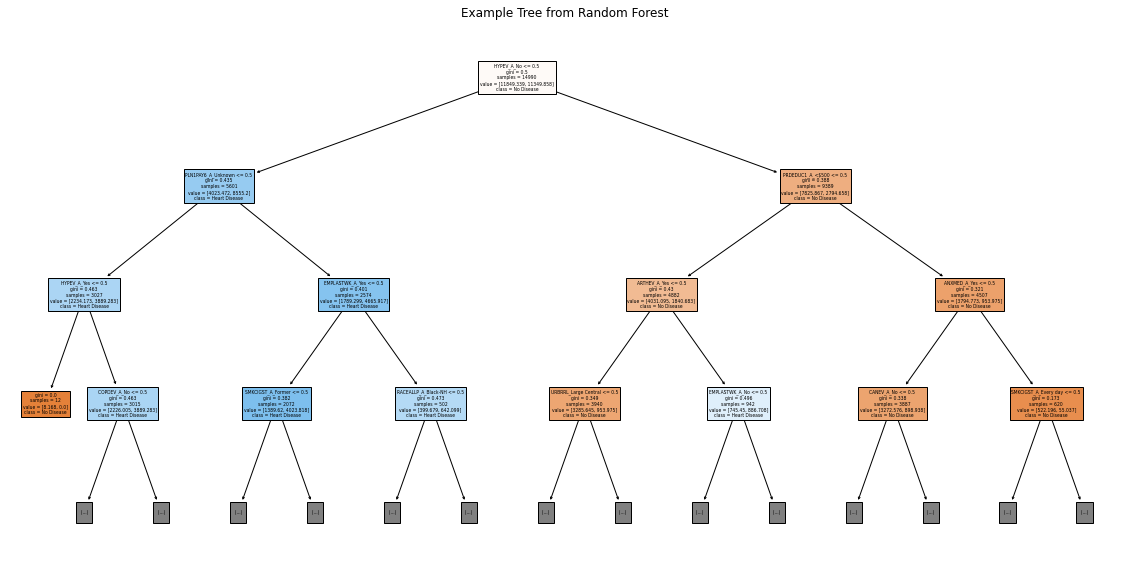

In [19]:
# Random forest viz
plt.figure(figsize=(20, 10))
plot_tree(best_rf_model.estimators_[0], 
          feature_names=X_final.columns,
          class_names=["No Disease", "Heart Disease"],
          max_depth=3, 
          filled=True)
plt.title("Example Tree from Random Forest")
plt.show()

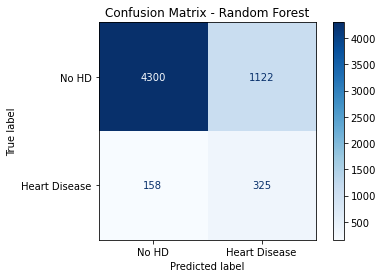

In [20]:
# Random forest confusion matrix
y_pred_rf = best_rf_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_rf)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No HD", "Heart Disease"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Random Forest")
plt.grid(False)
plt.show()

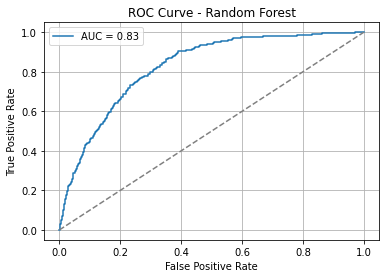

In [21]:
# Random forest ROC curve
y_probs_rf = best_rf_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs_rf)
auc = roc_auc_score(y_test, y_probs_rf)

plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.grid(True)
plt.show()

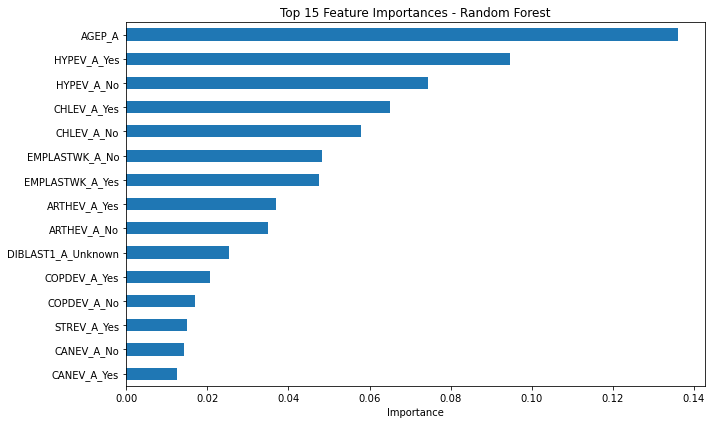

In [22]:
# Top 15 important features in random forest prediction
importances = best_rf_model.feature_importances_
feat_imp = pd.Series(importances, index=X_final.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
feat_imp.head(15).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Top 15 Feature Importances - Random Forest")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

In [23]:
# Gradient boosting model
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    scale_pos_weight= (len(y_train) - sum(y_train)) / sum(y_train), 
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

X_train.columns = [col.replace("[", "_").replace("]", "_").replace("<", "lt").replace(">", "gt").replace(" ", "_") 
                   for col in X_train.columns]
X_test.columns = [col.replace("[", "_").replace("]", "_").replace("<", "lt").replace(">", "gt").replace(" ", "_") 
                  for col in X_test.columns]

xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=3, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=42, reg_alpha=0, reg_lambda=1, ...)

In [24]:
y_pred_xgb = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.97      0.74      0.84      5422
           1       0.21      0.79      0.33       483

    accuracy                           0.74      5905
   macro avg       0.59      0.76      0.58      5905
weighted avg       0.91      0.74      0.80      5905



In [25]:
# Optimize gradient boosting model using hyperparameter tuning via GridSearch
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.01],
    'scale_pos_weight': [1, (len(y_train) - sum(y_train)) / sum(y_train)]
}

grid_xgb = GridSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_xgb.fit(X_train, y_train)
best_xgb_model = grid_xgb.best_estimator_
print("Best XGBoost Params:", grid_xgb.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best XGBoost Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'scale_pos_weight': 11.23045054375971}


In [26]:
# Gradient boosting model after hyperparameter tuning
y_pred_xgb = best_xgb_model.predict(X_test)
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.97      0.77      0.86      5422
           1       0.22      0.72      0.34       483

    accuracy                           0.77      5905
   macro avg       0.59      0.75      0.60      5905
weighted avg       0.91      0.77      0.82      5905



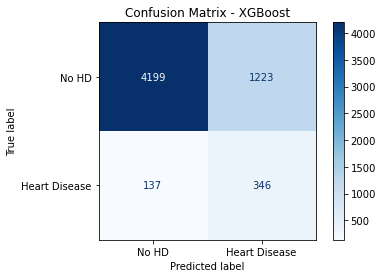

In [27]:
# Gradient boosting model confusion matrix
cm = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No HD", "Heart Disease"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - XGBoost")
plt.grid(False)
plt.show()

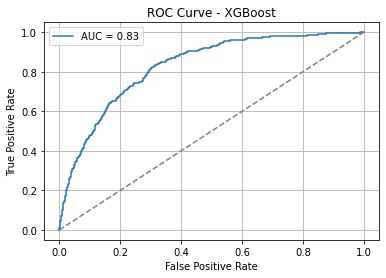

In [28]:
# Gradient boosting model ROC curve
y_probs_xgb = best_xgb_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs_xgb)
auc_score = roc_auc_score(y_test, y_probs_xgb)

plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost")
plt.legend()
plt.grid(True)
plt.show()

In [29]:
# CatBoost model
cat_cols = X.select_dtypes(include="string").columns.tolist()

X_train_cb, X_test_cb, y_train_cb, y_test_cb = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train_cb[cat_cols] = X_train_cb[cat_cols].astype(str)
X_test_cb[cat_cols] = X_test_cb[cat_cols].astype(str)

model_cb = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    loss_function='Logloss',
    eval_metric='F1',
    class_weights=[1, (len(y_train_cb) - sum(y_train_cb)) / sum(y_train_cb)],
    random_seed=42,
    verbose=100
)

model_cb.fit(
    X_train_cb,
    y_train_cb,
    cat_features=cat_cols, 
    eval_set=(X_test_cb, y_test_cb),
    early_stopping_rounds=50
)

0:	learn: 0.7397085	test: 0.7378160	best: 0.7378160 (0)	total: 84.2ms	remaining: 42s
100:	learn: 0.8026128	test: 0.7698916	best: 0.7703667 (84)	total: 3.43s	remaining: 13.6s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.772758584
bestIteration = 105

Shrink model to first 106 iterations.


In [30]:
y_pred_cb = model_cb.predict(X_test_cb)
print(classification_report(y_test_cb, y_pred_cb))

              precision    recall  f1-score   support

           0       0.98      0.73      0.83      5422
           1       0.21      0.80      0.33       483

    accuracy                           0.73      5905
   macro avg       0.59      0.76      0.58      5905
weighted avg       0.91      0.73      0.79      5905



In [31]:
# Optimize CatBoost model using hyperparameter tuning via GridSearch
param_grid_cb = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [200, 500],
    'l2_leaf_reg': [1, 3, 5],
}

cat_model = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='F1',
    class_weights=[1, (len(y_train_cb) - sum(y_train_cb)) / sum(y_train_cb)],
    cat_features=cat_cols,  
    verbose=0,
    random_seed=42
)

grid_cb = GridSearchCV(
    estimator=cat_model,
    param_grid=param_grid_cb,
    cv=3,
    scoring='f1',
    verbose=2
)

grid_cb.fit(X_train_cb, y_train_cb, cat_features=cat_cols)

best_cb_model = grid_cb.best_estimator_
print("Best CatBoost Parameters:", grid_cb.best_params_)

Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV] END depth=4, iterations=200, l2_leaf_reg=1, learning_rate=0.01; total time=   3.3s
[CV] END depth=4, iterations=200, l2_leaf_reg=1, learning_rate=0.01; total time=   3.3s
[CV] END depth=4, iterations=200, l2_leaf_reg=1, learning_rate=0.01; total time=   3.2s
[CV] END depth=4, iterations=200, l2_leaf_reg=1, learning_rate=0.05; total time=   3.4s
[CV] END depth=4, iterations=200, l2_leaf_reg=1, learning_rate=0.05; total time=   3.4s
[CV] END depth=4, iterations=200, l2_leaf_reg=1, learning_rate=0.05; total time=   3.5s
[CV] END depth=4, iterations=200, l2_leaf_reg=1, learning_rate=0.1; total time=   3.6s
[CV] END depth=4, iterations=200, l2_leaf_reg=1, learning_rate=0.1; total time=   3.6s
[CV] END depth=4, iterations=200, l2_leaf_reg=1, learning_rate=0.1; total time=   3.5s
[CV] END depth=4, iterations=200, l2_leaf_reg=3, learning_rate=0.01; total time=   3.3s
[CV] END depth=4, iterations=200, l2_leaf_reg=3, learning_rat

In [32]:
# CatBoost model after hyperparameter tuning
y_pred_cb = best_cb_model.predict(X_test_cb)
print(classification_report(y_test_cb, y_pred_cb))

              precision    recall  f1-score   support

           0       0.96      0.83      0.89      5422
           1       0.25      0.64      0.36       483

    accuracy                           0.81      5905
   macro avg       0.61      0.73      0.62      5905
weighted avg       0.90      0.81      0.85      5905



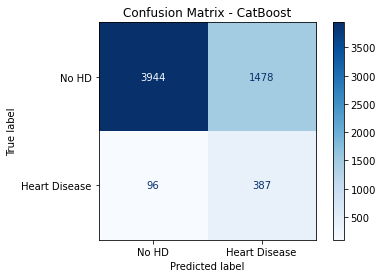

In [33]:
# Confusion matrix
y_pred_cb = model_cb.predict(X_test_cb)
cm = confusion_matrix(y_test_cb, y_pred_cb)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No HD", "Heart Disease"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - CatBoost")
plt.grid(False)
plt.show()

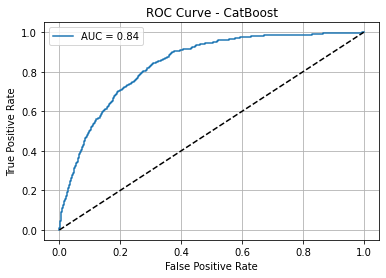

In [34]:
# CatBoost model ROC curve
y_probs_cb = model_cb.predict_proba(X_test_cb)[:, 1]
fpr, tpr, _ = roc_curve(y_test_cb, y_probs_cb)
auc = roc_auc_score(y_test_cb, y_probs_cb)

plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - CatBoost")
plt.legend()
plt.grid(True)
plt.show()

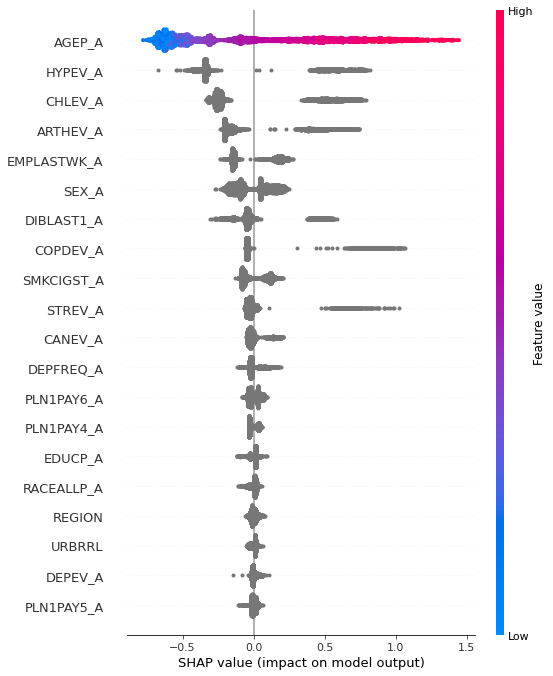

In [35]:
# SHAP plot
explainer = shap.TreeExplainer(model_cb)
shap_values = explainer.shap_values(X_test_cb)

shap.summary_plot(shap_values, X_test_cb)

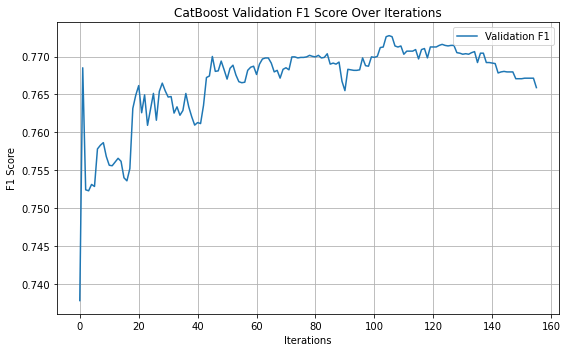

In [36]:
# CatBoost model eval metrics over time
eval_results = model_cb.get_evals_result()

plt.figure(figsize=(8, 5))
plt.plot(eval_results['validation']['F1'], label='Validation F1')
plt.xlabel("Iterations")
plt.ylabel("F1 Score")
plt.title("CatBoost Validation F1 Score Over Iterations")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()